# Анализ эксперимента по подстройке коэффициентов Kp и Ki от 26 ноября 2025


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from nn_laser_stabilizer.config import load_config

EXPERIMENT_DIR = Path("../experiments/pid_delta_tuning/2025-11-26_15-53-18")
CONFIG_PATH = EXPERIMENT_DIR / "config.yaml"
ENV_LOG_PATH = EXPERIMENT_DIR / "env_logs" / "env.log"
TRAIN_LOG_PATH = EXPERIMENT_DIR / "logs" / "train.log"
CONNECTION_LOG_PATH = EXPERIMENT_DIR / "connection_logs" / "connection.log"

config = load_config(CONFIG_PATH)
print(f"Эксперимент: {config.experiment_name}")
print(f"Seed: {config.seed}")


Эксперимент: pid_delta_tuning
Seed: 0


## Анализ логов окружения


In [2]:
def parse_env_logs(file_path):
    step_pattern = re.compile(
        r"step=(?P<step>\d+)\s+"
        r"time=(?P<time>-?\d+\.\d+)\s+"
        r"kp=(?P<kp>-?\d+\.\d+)\s+"
        r"ki=(?P<ki>-?\d+\.\d+)\s+"
        r"kd=(?P<kd>-?\d+\.\d+)\s+"
        r"delta_kp_norm=(?P<delta_kp_norm>-?\d+\.\d+)\s+"
        r"delta_ki_norm=(?P<delta_ki_norm>-?\d+\.\d+)\s+"
        r"error_mean_norm=(?P<error_mean_norm>-?\d+\.\d+)\s+"
        r"error_std_norm=(?P<error_std_norm>-?\d+\.\d+)\s+"
        r"reward=(?P<reward>-?\d+\.\d+)\s+"
        r"should_reset=(?P<should_reset>\w+)"
    )
    
    reset_pattern = re.compile(
        r"reset\s+time=(?P<time>-?\d+\.\d+)\s+"
        r"kp=(?P<kp>-?\d+\.\d+)\s+"
        r"ki=(?P<ki>-?\d+\.\d+)\s+"
        r"kd=(?P<kd>-?\d+\.\d+)\s+"
        r"error_mean_norm=(?P<error_mean_norm>-?\d+\.\d+)\s+"
        r"error_std_norm=(?P<error_std_norm>-?\d+\.\d+)"
    )
    
    rows = []
    reset_steps = []
    current_step = 0
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            reset_match = reset_pattern.match(line)
            if reset_match:
                reset_steps.append(current_step)
                rows.append({
                    'Step': current_step,
                    'time': float(reset_match.group('time')),
                    'Type': 'reset',
                    'Kp': float(reset_match.group('kp')),
                    'Ki': float(reset_match.group('ki')),
                    'Kd': float(reset_match.group('kd')),
                    'Delta Kp': np.nan,
                    'Delta Ki': np.nan,
                    'Error mean norm': float(reset_match.group('error_mean_norm')),
                    'Error std norm': float(reset_match.group('error_std_norm')),
                    'Reward': np.nan,
                    'Should reset': True
                })
                continue
            
            step_match = step_pattern.match(line)
            if step_match:
                current_step = int(step_match.group('step'))
                should_reset = step_match.group('should_reset').lower() == 'true'
                
                rows.append({
                    'Step': current_step,
                    'time': float(step_match.group('time')),
                    'Type': 'step',
                    'Kp': float(step_match.group('kp')),
                    'Ki': float(step_match.group('ki')),
                    'Kd': float(step_match.group('kd')),
                    'Delta Kp': float(step_match.group('delta_kp_norm')),
                    'Delta Ki': float(step_match.group('delta_ki_norm')),
                    'Error mean norm': float(step_match.group('error_mean_norm')),
                    'Error std norm': float(step_match.group('error_std_norm')),
                    'Reward': float(step_match.group('reward')),
                    'Should reset': should_reset
                })
    
    return pd.DataFrame(rows), reset_steps

env_df, reset_steps = parse_env_logs(ENV_LOG_PATH)
print(f"Загружено {len(env_df)} записей из логов окружения")
print(f"Найдено {len(reset_steps)} reset событий")
print(f"Диапазон шагов: {env_df['Step'].min()} - {env_df['Step'].max()}")


Загружено 5902 записей из логов окружения
Найдено 1 reset событий
Диапазон шагов: 0 - 5901


In [3]:
step_df = env_df[env_df['Type'] == 'step'].copy()
print("=== Статистика по шагам окружения ===")
print(step_df.describe())


=== Статистика по шагам окружения ===
              Step          time           Kp           Ki      Kd  \
count  5901.000000  5.901000e+03  5901.000000  5901.000000  5901.0   
mean   2951.000000  1.764162e+09     7.476184    14.329871     0.0   
std    1703.616301  2.078308e+03     1.142250     2.559223     0.0   
min       1.000000  1.764158e+09     5.452500     9.248900     0.0   
25%    1476.000000  1.764160e+09     6.650800    11.654700     0.0   
50%    2951.000000  1.764162e+09     6.829800    15.526100     0.0   
75%    4426.000000  1.764163e+09     8.598000    16.251900     0.0   
max    5901.000000  1.764165e+09    12.293000    20.000000     0.0   

          Delta Kp     Delta Ki  Error mean norm  Error std norm       Reward  
count  5901.000000  5901.000000      5901.000000     5901.000000  5901.000000  
mean     -0.001226     0.014965         0.000952        0.286093     0.666091  
std       0.379925     0.386821         0.044600        0.080151     0.105137  
min      -0

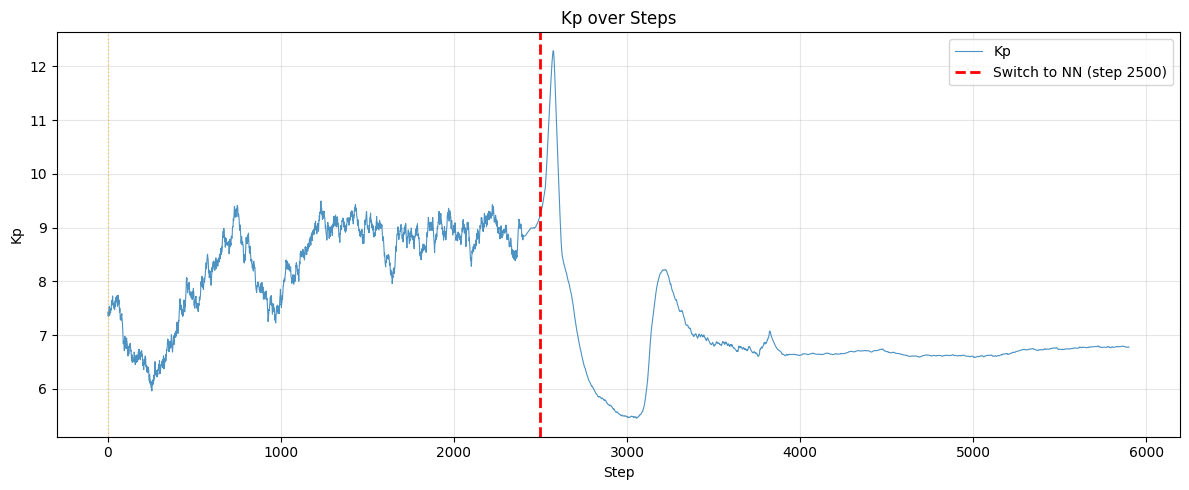

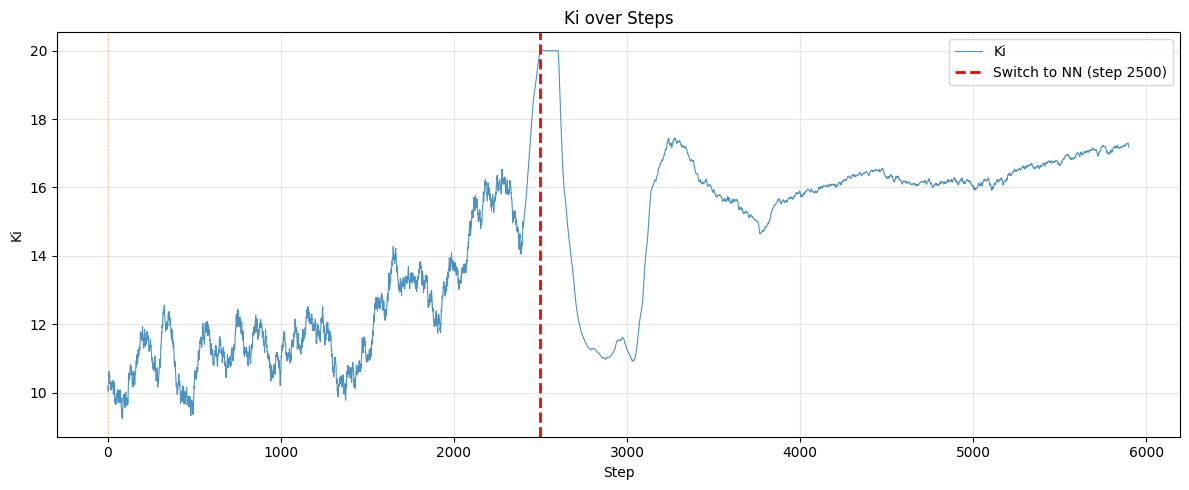

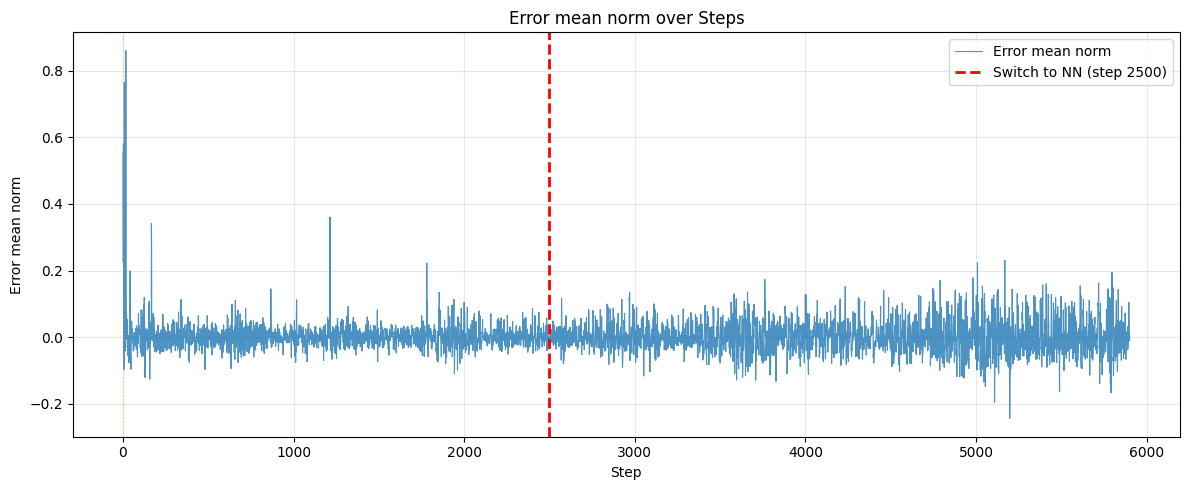

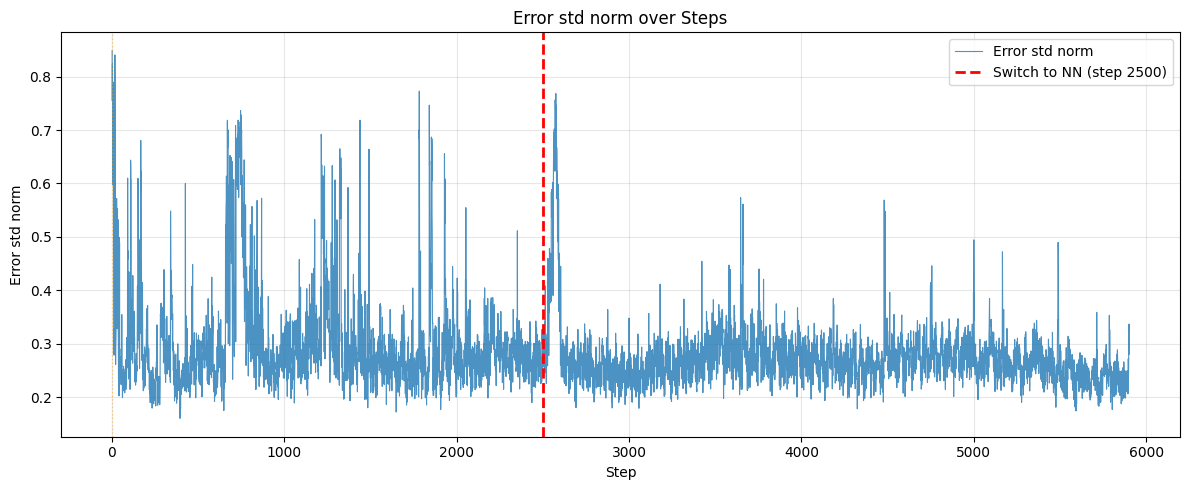

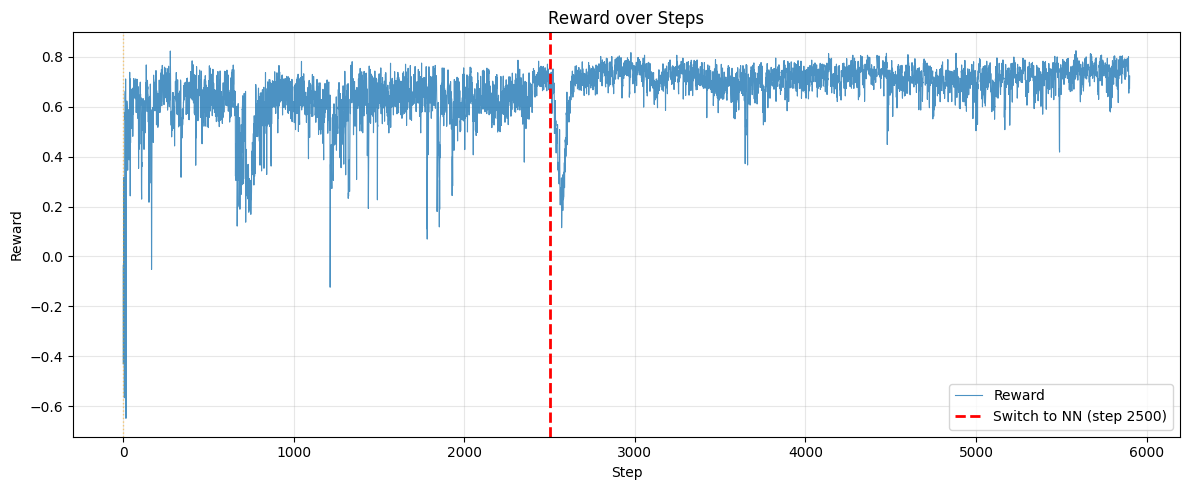

In [4]:
exploration_steps = config.training.exploration_steps
initial_collect_steps = config.training.initial_collect_steps
neural_network_step = max(initial_collect_steps, exploration_steps)

columns_to_plot = ['Kp', 'Ki', 'Error mean norm', 'Error std norm', 'Reward']

for col in columns_to_plot:
    plt.figure(figsize=(12, 5))
    plt.plot(step_df['Step'], step_df[col], alpha=0.8, linewidth=0.8, label=col)
    
    for reset_step in reset_steps:
        if reset_step <= step_df['Step'].max():
            plt.axvline(x=reset_step, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    
    if neural_network_step <= step_df['Step'].max():
        plt.axvline(x=neural_network_step, color='red', linestyle='--', linewidth=2, 
                    label=f'Switch to NN (step {neural_network_step})')
    
    plt.title(f'{col} over Steps')
    plt.xlabel('Step')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


C:\Users\artem\AppData\Local\Temp\ipykernel_36712\2231061363.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


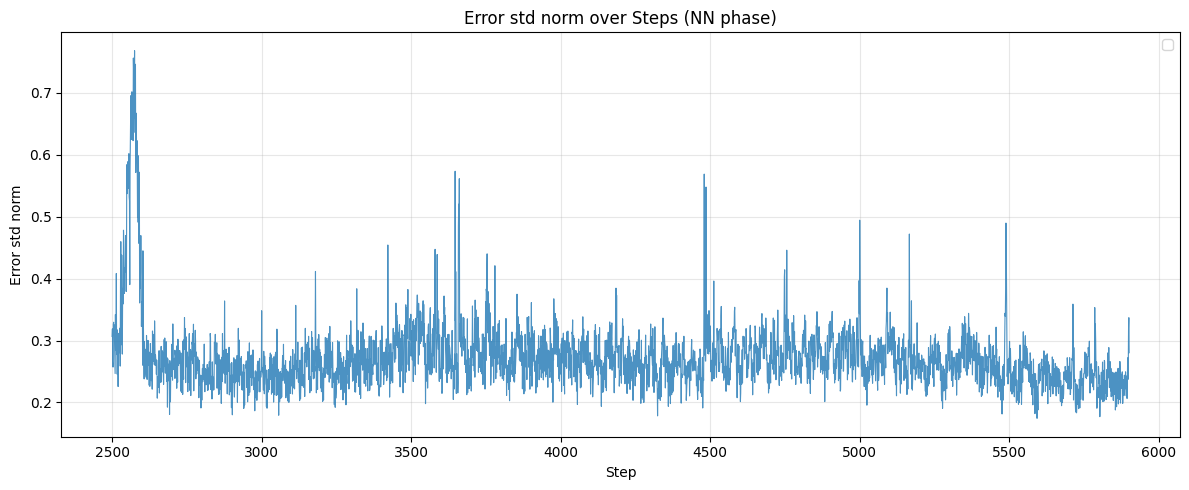

In [5]:
nn_step_df = step_df[step_df['Step'] >= neural_network_step].copy()

if len(nn_step_df) > 0:
    plt.figure(figsize=(12, 5))
    plt.plot(nn_step_df['Step'], nn_step_df['Error std norm'], alpha=0.8, linewidth=0.8)
    
    for reset_step in reset_steps:
        if reset_step >= neural_network_step and reset_step <= nn_step_df['Step'].max():
            plt.axvline(x=reset_step, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='Reset' if reset_step == reset_steps[0] else '')
    
    plt.title('Error std norm over Steps (NN phase)')
    plt.xlabel('Step')
    plt.ylabel('Error std norm')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


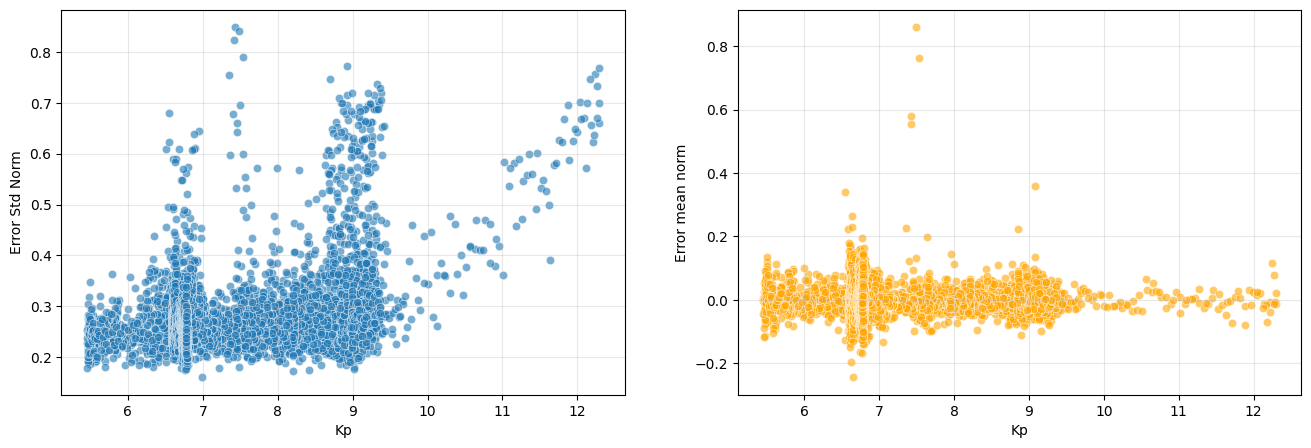

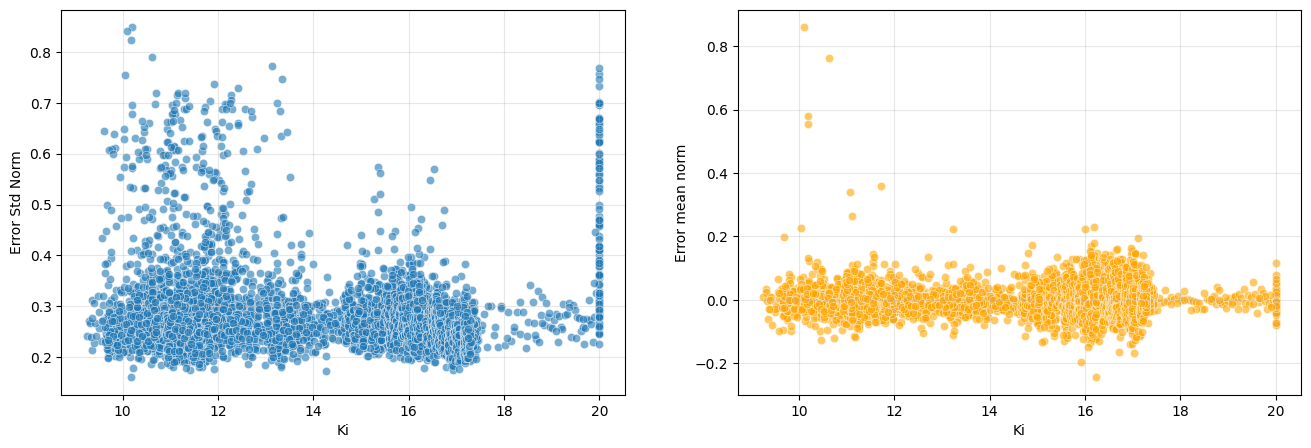

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
cur_ax = axes[0]
sns.scatterplot(x=step_df['Kp'], y=step_df['Error std norm'], alpha=0.6, ax=cur_ax)
cur_ax.set_xlabel('Kp')
cur_ax.set_ylabel('Error Std Norm')
cur_ax.grid(True, alpha=0.3)

cur_ax = axes[1]
sns.scatterplot(x=step_df['Kp'], y=step_df['Error mean norm'], alpha=0.6, ax=cur_ax, color='orange')
cur_ax.set_xlabel('Kp')
cur_ax.set_ylabel('Error mean norm')
cur_ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
cur_ax = axes[0]
sns.scatterplot(x=step_df['Ki'], y=step_df['Error std norm'], alpha=0.6, ax=cur_ax)
cur_ax.set_xlabel('Ki')
cur_ax.set_ylabel('Error Std Norm')
cur_ax.grid(True, alpha=0.3)

cur_ax = axes[1]
sns.scatterplot(x=step_df['Ki'], y=step_df['Error mean norm'], alpha=0.6, ax=cur_ax, color='orange')
cur_ax.set_xlabel('Ki')
cur_ax.set_ylabel('Error mean norm')
cur_ax.grid(True, alpha=0.3)


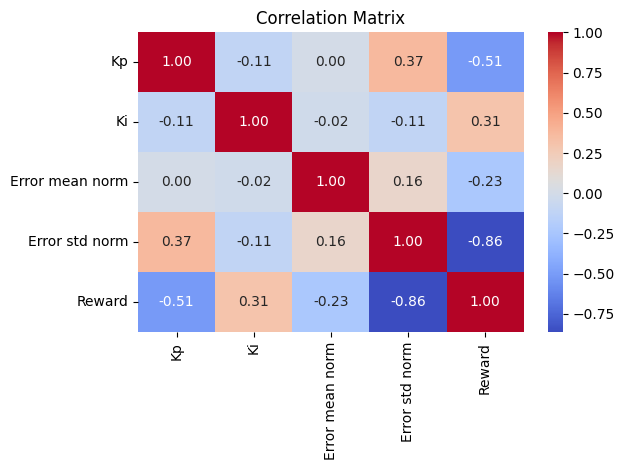

In [7]:
corr_matrix = step_df[['Kp', 'Ki', 'Error mean norm', 'Error std norm', 'Reward']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


## Анализ процесса обучения


In [8]:
def parse_train_logs(file_path):
    pattern = re.compile(
        r"step=(?P<step>\d+)\s+"
        r"time=(?P<time>-?\d+\.\d+)\s+"
        r"loss_q1=(?P<loss_q1>-?\d+\.\d+)\s+"
        r"loss_q2=(?P<loss_q2>-?\d+\.\d+)\s+"
        r"(actor_loss=(?P<actor_loss>-?\d+\.\d+)\s+)?"
        r"buffer_size=(?P<buffer_size>\d+)"
    )
    
    rows = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            match = pattern.match(line)
            if match:
                actor_loss = match.group('actor_loss')
                rows.append({
                    'step': int(match.group('step')),
                    'loss_q1': float(match.group('loss_q1')),
                    'loss_q2': float(match.group('loss_q2')),
                    'actor_loss': float(actor_loss) if actor_loss else np.nan,
                    'buffer_size': int(match.group('buffer_size'))
                })
    
    return pd.DataFrame(rows)

loss_df = parse_train_logs(TRAIN_LOG_PATH)
print(f"Загружено {len(loss_df)} записей из логов обучения")
print(f"Диапазон шагов обучения: {loss_df['step'].min()} - {loss_df['step'].max()}")


Загружено 39010 записей из логов обучения
Диапазон шагов обучения: 0 - 39009


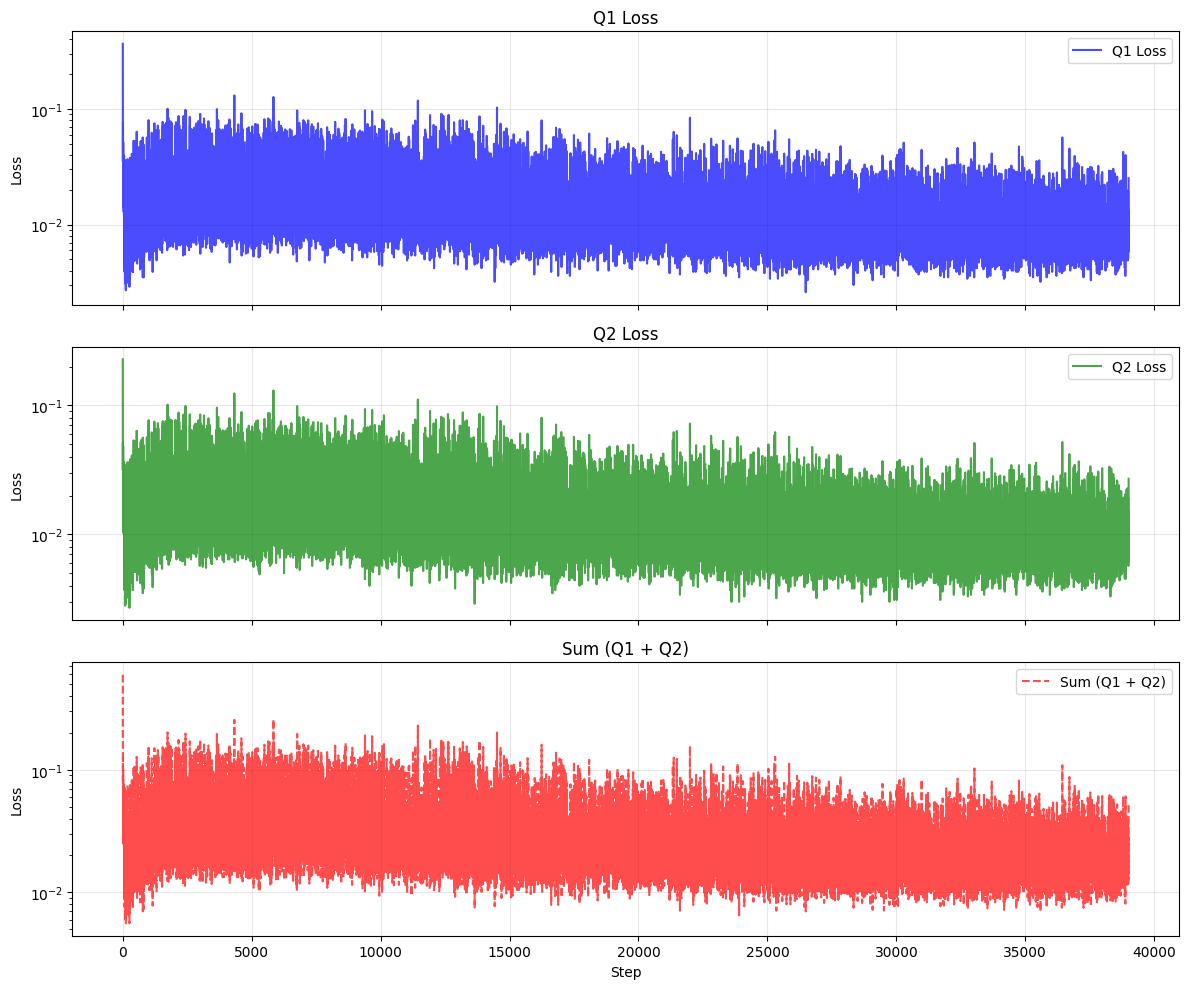

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(loss_df['step'], loss_df['loss_q1'], 'b-', alpha=0.7, label='Q1 Loss')
axes[0].set_title('Q1 Loss')
axes[0].set_ylabel('Loss')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(loss_df['step'], loss_df['loss_q2'], 'g-', alpha=0.7, label='Q2 Loss')
axes[1].set_title('Q2 Loss')
axes[1].set_ylabel('Loss')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(loss_df['step'], loss_df['loss_q1'] + loss_df['loss_q2'], 'r--', alpha=0.7, label='Sum (Q1 + Q2)')
axes[2].set_title('Sum (Q1 + Q2)')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Loss')
axes[2].set_yscale('log')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

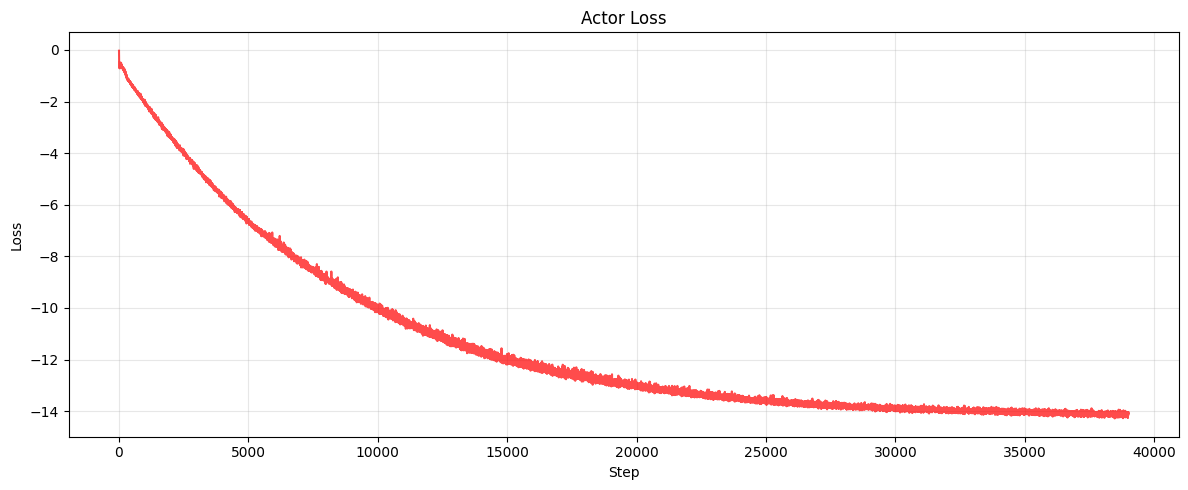

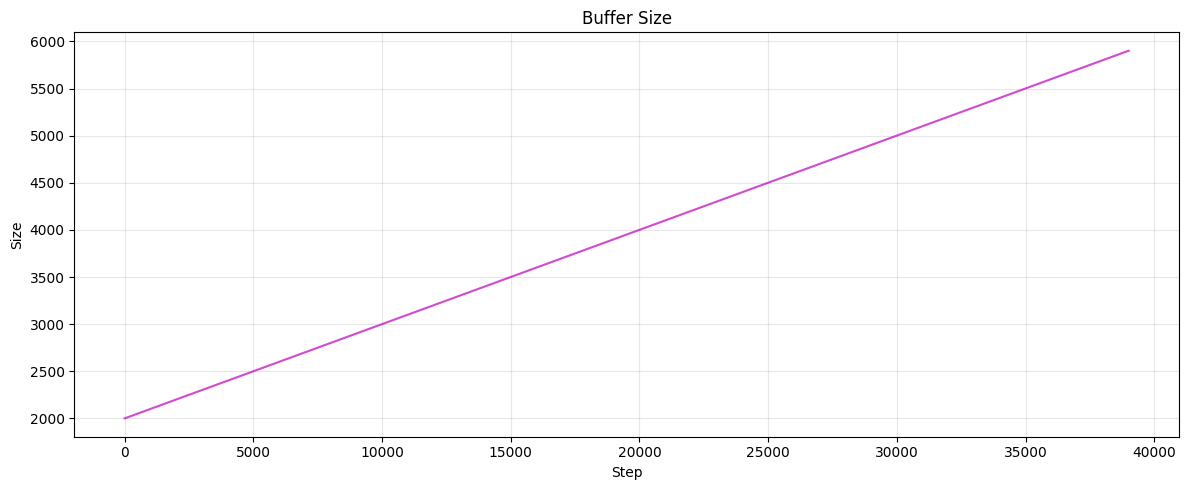

In [10]:
plt.figure(figsize=(12, 5))
actor_loss_df = loss_df[loss_df['actor_loss'].notna()]
if len(actor_loss_df) > 0:
    plt.plot(actor_loss_df['step'], actor_loss_df['actor_loss'], 'r-', alpha=0.7)
    plt.title('Actor Loss')
else:
    plt.text(0.5, 0.5, 'No actor loss data', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Actor Loss (no data)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(loss_df['step'], loss_df['buffer_size'], 'm-', alpha=0.7)
plt.title('Buffer Size')
plt.xlabel('Step')
plt.ylabel('Size')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Анализ состояния установки


In [11]:
def parse_connection_logs(file_path):
    send_pattern = re.compile(r"SEND: kp=(?P<kp>-?\d+\.\d+) ki=(?P<ki>-?\d+\.\d+) kd=(?P<kd>-?\d+\.\d+) control_min=(?P<control_min>\d+) control_max=(?P<control_max>\d+)")
    read_pattern = re.compile(r"READ: process_variable=(?P<process_variable>-?\d+\.\d+) control_output=(?P<control_output>-?\d+\.\d+)")
    
    send_rows = []
    read_rows = []
    step = 0
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            send_match = send_pattern.match(line)
            if send_match:
                send_rows.append({
                    'step': step,
                    'type': 'SEND',
                    'kp': float(send_match.group('kp')),
                    'ki': float(send_match.group('ki')),
                    'kd': float(send_match.group('kd')),
                    'control_min': int(send_match.group('control_min')),
                    'control_max': int(send_match.group('control_max'))
                })
                step += 1
            
            read_match = read_pattern.match(line)
            if read_match:
                read_rows.append({
                    'step': step - 1,
                    'type': 'READ',
                    'process_variable': float(read_match.group('process_variable')),
                    'control_output': float(read_match.group('control_output'))
                })
    
    connection_df = pd.DataFrame(send_rows)
    read_df = pd.DataFrame(read_rows)
    
    if not connection_df.empty and not read_df.empty:
        connection_df = connection_df.merge(read_df[['step', 'process_variable', 'control_output']], 
                                          on='step', how='left')
    
    return connection_df

connection_df = parse_connection_logs(CONNECTION_LOG_PATH)
print(f"Загружено {len(connection_df)} записей из логов соединения")
if len(connection_df) > 0:
    print(f"Диапазон шагов: {connection_df['step'].min()} - {connection_df['step'].max()}")


Загружено 1181471 записей из логов соединения
Диапазон шагов: 0 - 1181470


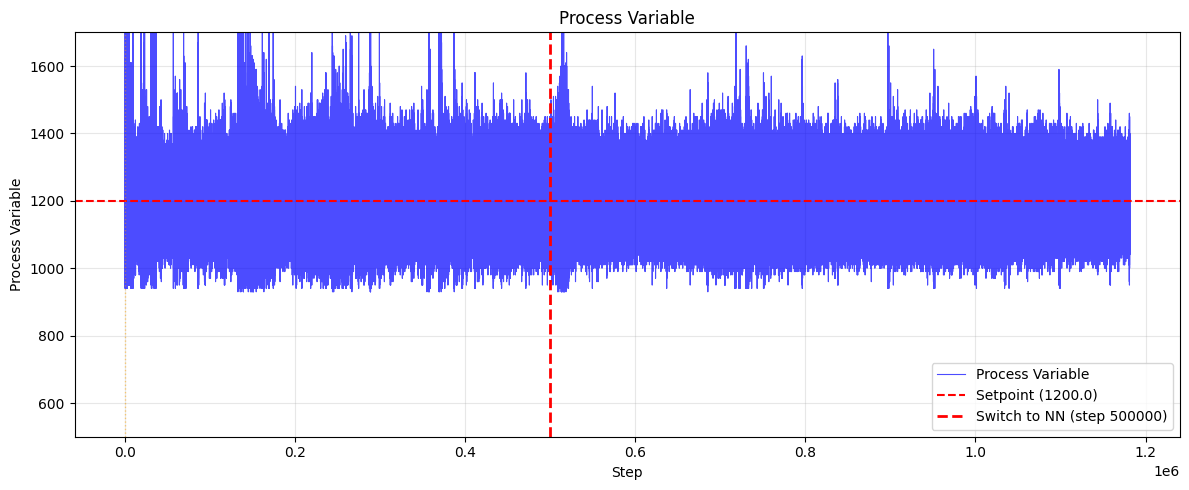

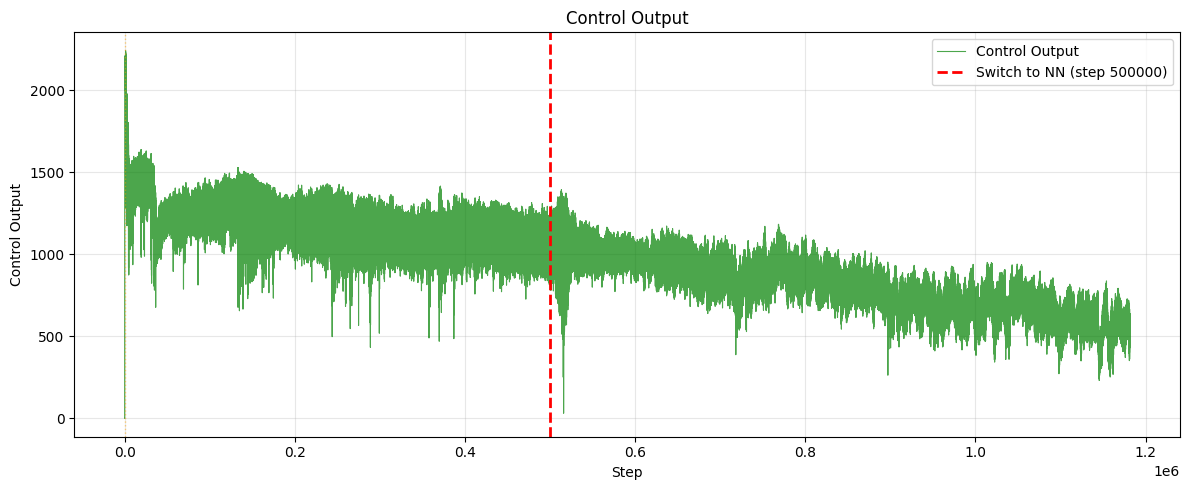

C:\Users\artem\AppData\Local\Temp\ipykernel_36712\2394845293.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\artem\miniconda3\envs\nn-laser-stabilizer\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


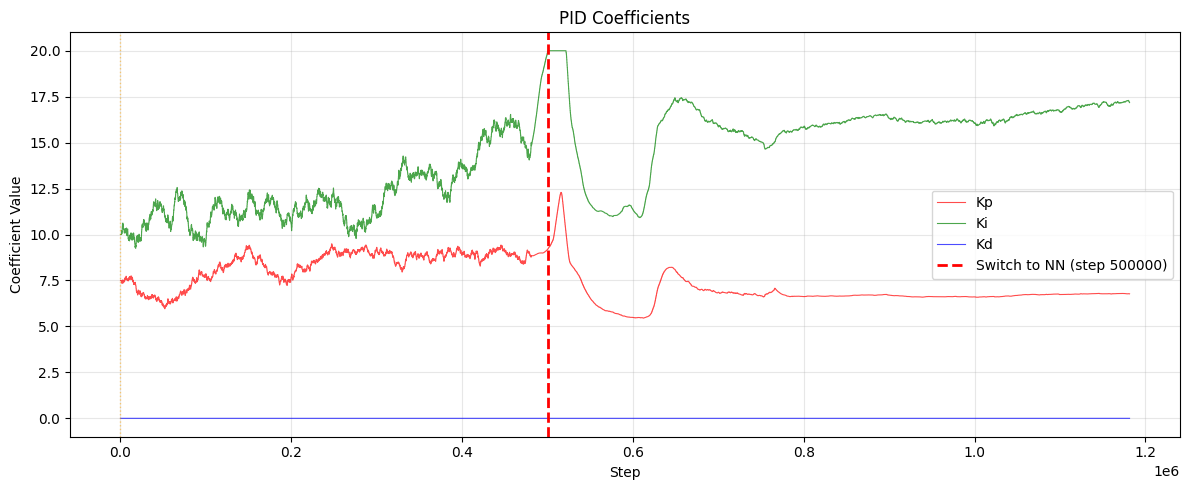

In [12]:
neural_network_step = max(initial_collect_steps, exploration_steps) * config.env.args.block_size
if len(connection_df) > 0:
    setpoint = config.env.args.setpoint
    
    plt.figure(figsize=(12, 5))
    plt.plot(connection_df['step'], connection_df['process_variable'], 'b-', alpha=0.7, linewidth=0.8, label='Process Variable')
    plt.axhline(y=setpoint, color='r', linestyle='--', label=f'Setpoint ({setpoint})')
    
    for reset_step in reset_steps:
        if reset_step <= connection_df['step'].max():
            plt.axvline(x=reset_step, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    
    if neural_network_step <= connection_df['step'].max():
        plt.axvline(x=neural_network_step, color='red', linestyle='--', linewidth=2, 
                    label=f'Switch to NN (step {neural_network_step})')
    
    plt.title('Process Variable')
    plt.xlabel('Step')
    plt.ylim(500, 1700)
    plt.ylabel('Process Variable')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(connection_df['step'], connection_df['control_output'], 'g-', alpha=0.7, linewidth=0.8, label='Control Output')
    
    for reset_step in reset_steps:
        if reset_step <= connection_df['step'].max():
            plt.axvline(x=reset_step, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    
    if neural_network_step <= connection_df['step'].max():
        plt.axvline(x=neural_network_step, color='red', linestyle='--', linewidth=2, 
                    label=f'Switch to NN (step {neural_network_step})')
    
    plt.title('Control Output')
    plt.xlabel('Step')
    plt.ylabel('Control Output')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(connection_df['step'], connection_df['kp'], 'r-', alpha=0.7, linewidth=0.8, label='Kp')
    plt.plot(connection_df['step'], connection_df['ki'], 'g-', alpha=0.7, linewidth=0.8, label='Ki')
    plt.plot(connection_df['step'], connection_df['kd'], 'b-', alpha=0.7, linewidth=0.8, label='Kd')
    
    for reset_step in reset_steps:
        if reset_step <= connection_df['step'].max():
            plt.axvline(x=reset_step, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    
    if neural_network_step <= connection_df['step'].max():
        plt.axvline(x=neural_network_step, color='red', linestyle='--', linewidth=2, 
                    label=f'Switch to NN (step {neural_network_step})')
    
    plt.title('PID Coefficients')
    plt.xlabel('Step')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


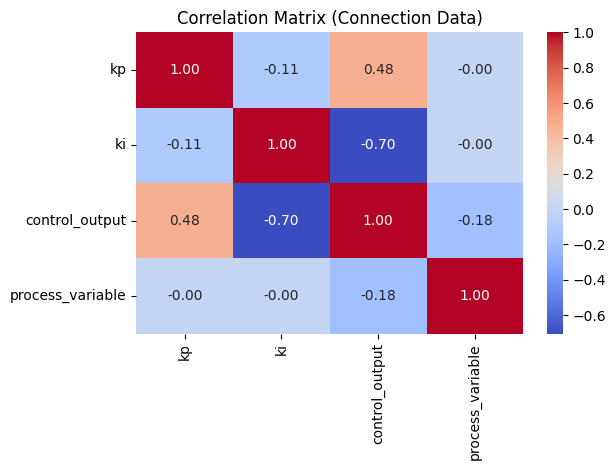

In [13]:
if len(connection_df) > 0:
    corr_matrix = connection_df[['kp', 'ki', 'control_output', 'process_variable']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix (Connection Data)')
    plt.tight_layout()
    plt.show()


=== Статистика по времени ===
Всего записей: 5902
Шагов: 5901
Reset событий: 1

=== Статистика интервалов между шагами ===
count    5900.000000
mean     1219.939535
std         5.495054
min      1204.003096
25%      1216.521502
50%      1219.127417
75%      1223.101616
max      1235.788107
Name: time_diff_ms, dtype: float64

Медианный интервал: 1219.13 мс
Средний интервал: 1219.94 мс
Максимальный интервал: 1235.79 мс
Минимальный интервал: 1204.00 мс


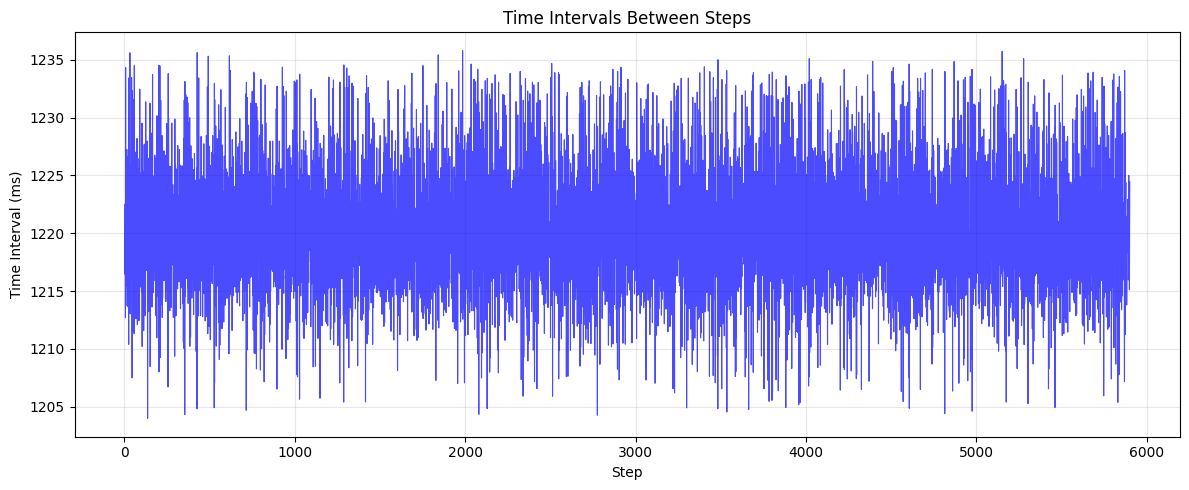

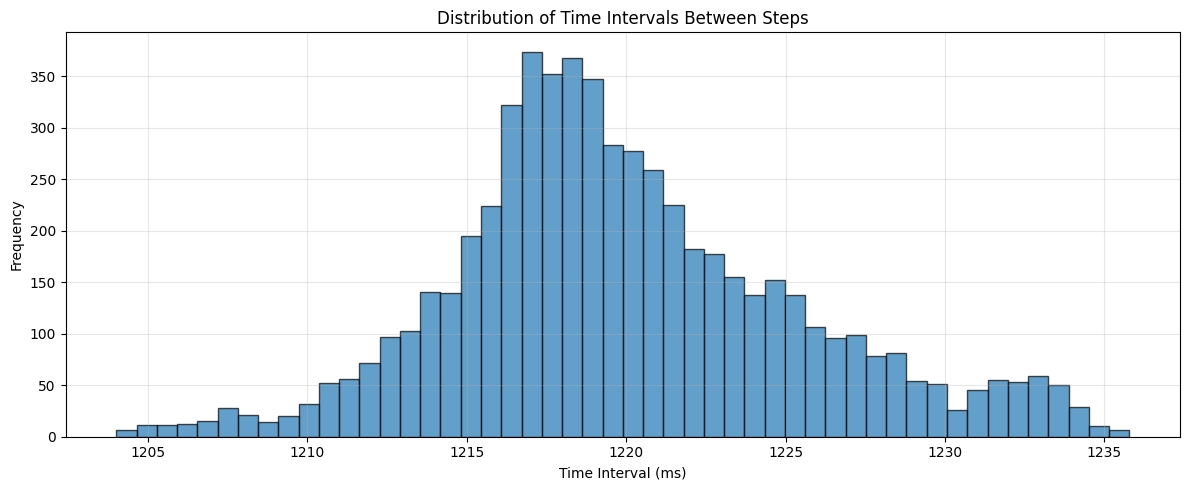

In [14]:
step_df = step_df.sort_values('time')
step_df['time_diff'] = step_df['time'].diff()
step_df['time_diff_ms'] = step_df['time_diff'] * 1000 
if len(step_df) > 0:
    step_df['time_relative'] = step_df['time'] - step_df['time'].iloc[0]
    step_df['time_relative_minutes'] = step_df['time_relative'] / 60

time_df, step_time_df = env_df.copy(), step_df.copy()

print("=== Статистика по времени ===")
print(f"Всего записей: {len(time_df)}")
print(f"Шагов: {len(time_df[time_df['Type'] == 'step'])}")
print(f"Reset событий: {len(time_df[time_df['Type'] == 'reset'])}")

if len(step_time_df) > 0:
    print(f"\n=== Статистика интервалов между шагами ===")
    print(step_time_df['time_diff_ms'].describe())
    print(f"\nМедианный интервал: {step_time_df['time_diff_ms'].median():.2f} мс")
    print(f"Средний интервал: {step_time_df['time_diff_ms'].mean():.2f} мс")
    print(f"Максимальный интервал: {step_time_df['time_diff_ms'].max():.2f} мс")
    print(f"Минимальный интервал: {step_time_df['time_diff_ms'].min():.2f} мс")
    
    plt.figure(figsize=(12, 5))
    plt.plot(step_time_df['Step'], step_time_df['time_diff_ms'], 'b-', alpha=0.7, linewidth=0.8)
    plt.title('Time Intervals Between Steps')
    plt.xlabel('Step')
    plt.ylabel('Time Interval (ms)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.hist(step_time_df['time_diff_ms'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Time Intervals Between Steps')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()